In [23]:
from IPython.display import clear_output
# !pip install stanza
# from google.colab import drive
# drive.mount('/content/drive')

import os

import pandas as pd

import torch
from torchtext.legacy import data
import torch.nn as nn
import numpy as np

clear_output()
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
base_path = os.path.abspath('..')
project_path = os.path.join(base_path, 'emotion-classification')

df = pd.read_csv(os.path.join(project_path, 'data/train.csv'), index_col=0)
df = pd.concat([df, pd.read_csv(os.path.join(project_path, 'data/test.csv'), index_col=0)])

# Only include utterances with more than 5 characters
df = df[df['prompt'].str.len() > 5]
df = df.reset_index(drop=True)

# Add _text suffix
df.rename({'prompt': 'prompt_text'}, axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df.head()

,prompt_text,label
0,I remember going to the fireworks with my best...,sentimental
1,i used to scare for darkness,afraid
2,I showed a guy how to run a good bead in weldi...,proud
3,I have always been loyal to my wife.,faithful
4,A recent job interview that I had made me feel...,terrified


In [25]:
emotion_consolidation = {
    'mad': ['angry', 'jealous', 'annoyed', 'furious', 'disgusted', ],
    'sad': ['devastated', 'ashamed', 'sad', 'ashamed', 'guilty', 'disappointed', 'embarrassed', 'lonely'],
    'joyful': ['joyful', 'excited', 'trusting', 'caring', 'grateful', 'hopeful', 'content'],
    'powerful': ['confident', 'prepared', 'proud', 'faithful'],
    'peaceful': [],
    'scared': ['anxious', 'apprehensive', 'terrified', 'afraid']
}
# 
# for ix in df['label'].index:
    # for basal_emotion, higher_emotions in emotion_consolidation.items():
        # if df.loc[ix, 'label'] in higher_emotions:
            # df.loc[ix, 'label'] = basal_emotion
# 
# df['label'] = label_encoder.fit_transform(df['label'])

In [26]:
for ix in df['label'].index:
    found = False
    for basal_emotion, higher_emotions in emotion_consolidation.items():
        if df.loc[ix, 'label'] in higher_emotions:
            df.loc[ix, 'label'] = basal_emotion
            found = True
    if not found:
        df = df.drop(ix)
        

df['label'] = label_encoder.fit_transform(df['label'])

n_labels = len(df['label'].unique())
df['label'].value_counts()

0    4923
3    4879
1    3725
4    2756
2    2661
Name: label, dtype: int64

In [27]:
df

,prompt_text,label
1,i used to scare for darkness,4
2,I showed a guy how to run a good bead in weldi...,2
3,I have always been loyal to my wife.,2
4,A recent job interview that I had made me feel...,4
5,I am very happy to have been first over 300 st...,0
...,...,...
22914,"My daughter has been sick, but it looks like s...",0
22916,Had to cancel our family vacation coming up ne...,3
22917,I'm glad that life is being good to me,0
22918,I saw a huge cockroach outside my house today....,1


In [28]:
df['label'].value_counts()

0    4923
3    4879
1    3725
4    2756
2    2661
Name: label, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state=42, test_size=0.2)
train_df, val_df = train_test_split(train_df, random_state=42, test_size=0.2)

In [30]:
TEXT = data.Field(tokenize = 'moses', include_lengths = True)
LABEL = data.LabelField()

In [31]:
class DataFrameDataset(data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.label if not is_test else None
            text = row.prompt_text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


In [32]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds, test_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=val_df, test_df=test_df)

In [33]:
MAX_VOCAB_SIZE = 25000

# all possible embedding options:
# fasttext.en.300d fasttext.simple.300d glove.42B.300d 
# glove.840B.300d glove.twitter.27B.25d glove.twitter.27B.50d 
# glove.twitter.27B.100d glove.twitter.27B.200d glove.6B.50d 
# glove.6B.100d glove.6B.200d glove.6B.300d
TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

In [34]:
LABEL.build_vocab(train_ds)

In [35]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [36]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 512
OUTPUT_DIM = n_labels
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [37]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text dims: [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded dims:  [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu().int())
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output dims: [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden dims: [num layers * num directions, batch size, hid dim]
        #cell dims: [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # these are the outputs from the last token
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden dims: [batch size, hid dim * num directions]
            
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        return self.fc2(hidden)


In [38]:
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [39]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3581,  0.1035, -0.2837,  ...,  0.8999, -0.0199,  0.2987],
        [ 0.0623, -0.7013, -0.4708,  ...,  0.5110, -0.2204, -0.1306],
        [ 0.2175, -0.1179, -0.0888,  ...,  0.2764,  0.1405,  0.9922]])

In [40]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# print(model.embedding.weight.data[0])

In [41]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
from sklearn.metrics import f1_score
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths.int()).squeeze(1)
        # print(predictions.shape)
        loss = criterion(predictions, batch.label)

        loss.backward()
        optimizer.step()
        preds = torch.argmax(predictions, 1).cpu()
        acc = f1_score(preds, batch.label.cpu(), average='macro')
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [43]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths.cpu().int()).squeeze(1)
            preds = torch.argmax(predictions, 1).cpu()
            acc = f1_score(preds, batch.label.cpu(), average='macro')
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [44]:
import time
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 1.244 | Train Acc: 42.84%
	 Val. Acc: 59.06%
	Train Loss: 0.883 | Train Acc: 64.91%
	 Val. Acc: 69.02%
	Train Loss: 0.694 | Train Acc: 72.74%
	 Val. Acc: 70.04%
	Train Loss: 0.537 | Train Acc: 79.83%
	 Val. Acc: 71.20%
	Train Loss: 0.436 | Train Acc: 84.13%
	 Val. Acc: 70.05%
	Train Loss: 0.338 | Train Acc: 87.47%
	 Val. Acc: 69.93%
	Train Loss: 0.251 | Train Acc: 90.95%
	 Val. Acc: 70.56%
	Train Loss: 0.196 | Train Acc: 93.12%
	 Val. Acc: 68.38%
	Train Loss: 0.156 | Train Acc: 94.49%
	 Val. Acc: 68.46%
	Train Loss: 0.132 | Train Acc: 95.15%
	 Val. Acc: 69.56%
	Train Loss: 0.094 | Train Acc: 96.59%
	 Val. Acc: 69.26%
	Train Loss: 0.070 | Train Acc: 97.35%
	 Val. Acc: 68.12%
	Train Loss: 0.062 | Train Acc: 97.75%
	 Val. Acc: 68.12%
	Train Loss: 0.063 | Train Acc: 97.67%
	 Val. Acc: 68.00%
	Train Loss: 0.047 | Train Acc: 98.25%
	 Val. Acc: 68.66%
	Train Loss: 0.034 | Train Acc: 98.87%
	 Val. Acc: 68.95%
	Train Loss: 0.020 | Train Acc: 99.29%
	 Val. Acc: 68.21%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

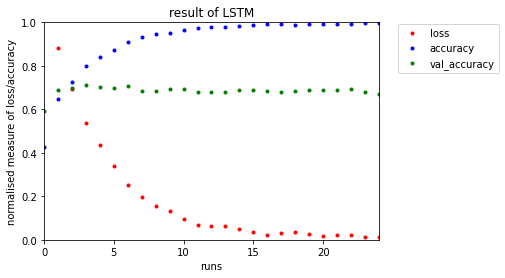

In [45]:
import matplotlib.pyplot as plt

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

## Transfer Learning with BERT 

In [46]:
import transformers
from transformers import AutoModel, BertTokenizerFast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, BertTokenizerFast

# specify GPU
device = torch.device("cuda")



In [47]:
# import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

task='sentiment'
model = 'bert-base-uncased'
# model = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
# model = f"cardiffnlp/twitter-roberta-base-{task}"
# model = 'BertForSequenceClassification'
bert = AutoModel.from_pretrained(model, return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
train_text, train_labels = train_df['prompt_text'].str.lower(), train_df['label']

val_text, val_labels = val_df['prompt_text'].str.lower(), val_df['label']

test_text, test_labels = test_df['prompt_text'].str.lower(), test_df['label']

<AxesSubplot:>

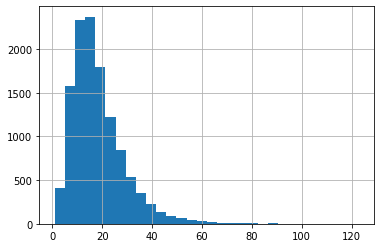

In [49]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [50]:
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [51]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 150,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 150,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 150,
    pad_to_max_length=True,
    truncation=True
)


/home/aaron/miniconda3/envs/deep-learning/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [32]:
# freeze all the parameters
for param in bert.parameters():
    # print(param.shape)
    param.requires_grad = False
    # if param.shape

In [33]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,1024)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(1024,512)

      # dense layer 2 (Output layer)
      self.fc3 = nn.Linear(512, n_labels)

      # #softmax activation function
      # self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      # print(cls_hs)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.relu(self.fc2(x))

      # output layer
      x = self.fc3(x)
      
      # apply softmax activation
      # x = self.softmax(x)

      return x


In [34]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


In [35]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate


In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)


Class Weights: [0.77717949 0.99868204 1.40649652 0.77942784 1.39276278]


In [37]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10


In [38]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [39]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # 
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 200 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = print(time.time() - t0)
      pass
      # Report progress.
      # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      predictions = torch.argmax(preds, 1).cpu()

      preds = preds.detach().cpu().numpy()
      
      # acc = f1_score(labels.cpu(), predictions, average='macro')
      total_preds.append(predictions)
      total_labels.append(labels.cpu())

      # print(acc)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_labels  = np.concatenate(total_labels, axis=0)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds, total_labels


In [40]:
from sklearn.metrics import accuracy_score

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs=25

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, preds, labels = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print("F1:", f1_score(labels, preds, average='macro'), flush=True)
    print("Accuracy:", accuracy_score(labels, preds), flush=True)




 Epoch 1 / 25

Evaluating...

Training Loss: 1.609
Validation Loss: 1.606
F1: 0.2523362710323725
Accuracy: 0.2946222368855163

 Epoch 2 / 25

Evaluating...

Training Loss: 1.606
Validation Loss: 1.600
F1: 0.19874479102803527
Accuracy: 0.301550643352029

 Epoch 3 / 25

Evaluating...

Training Loss: 1.603
Validation Loss: 1.595
F1: 0.2443448537437714
Accuracy: 0.3051798086440119

 Epoch 4 / 25

Evaluating...

Training Loss: 1.599
Validation Loss: 1.587
F1: 0.24616461733848416
Accuracy: 0.3322335862751567

 Epoch 5 / 25

Evaluating...

Training Loss: 1.594
Validation Loss: 1.581
F1: 0.3081786914391485
Accuracy: 0.3447707027383702

 Epoch 6 / 25

Evaluating...

Training Loss: 1.588
Validation Loss: 1.572
F1: 0.29780509053223614
Accuracy: 0.35466842626195977

 Epoch 7 / 25

Evaluating...

Training Loss: 1.585
Validation Loss: 1.566
F1: 0.2970936800230877
Accuracy: 0.3140877598152425

 Epoch 8 / 25

Evaluating...

Training Loss: 1.579
Validation Loss: 1.558
F1: 0.31763463171834516
Accuracy:

## Transfer Learning with BERT 

In [41]:
import transformers
from transformers import AutoModel, BertTokenizerFast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, BertTokenizerFast

# specify GPU
device = torch.device("cuda")



In [42]:
# import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

task='sentiment'
model = 'bert-base-uncased'
# model = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
# model = f"cardiffnlp/twitter-roberta-base-{task}"
# model = 'BertForSequenceClassification'
bert = AutoModel.from_pretrained(model, return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
train_text, train_labels = train_df['prompt_text'].str.lower(), train_df['label']

val_text, val_labels = val_df['prompt_text'].str.lower(), val_df['label']

test_text, test_labels = test_df['prompt_text'].str.lower(), test_df['label']

<AxesSubplot:>

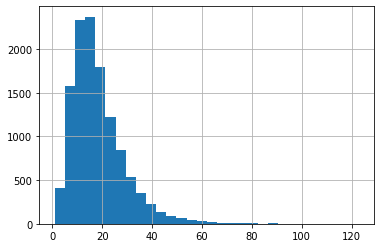

In [44]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [45]:
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [46]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)


/home/aaron/miniconda3/envs/deep-learning/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [48]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [49]:
# freeze all the parameters
for param in bert.parameters():
    print(param.shape)
    param.requires_grad = True
    # if param.shape

torch.Size([30522, 768])
torch.Size([512, 768])
torch.Size([2, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size

In [50]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,1024)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(1024,512)

      # dense layer 2 (Output layer)
      self.fc3 = nn.Linear(512,n_labels)

      # #softmax activation function
      # self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      # print(cls_hs)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.relu(self.fc2(x))

      # output layer
      x = self.fc3(x)
      
      # apply softmax activation
      # x = self.softmax(x)

      return x


In [51]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


In [52]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-3)          # learning rate


In [53]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)


Class Weights: [0.77717949 0.99868204 1.40649652 0.77942784 1.39276278]


In [54]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10


In [55]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [56]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # 
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 200 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = print(time.time() - t0)
      pass
      # Report progress.
      # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      predictions = torch.argmax(preds, 1).cpu()

      preds = preds.detach().cpu().numpy()
      
      # acc = f1_score(labels.cpu(), predictions, average='macro')
      total_preds.append(predictions)
      total_labels.append(labels.cpu())

      # print(acc)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_labels  = np.concatenate(total_labels, axis=0)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds, total_labels


In [57]:
from sklearn.metrics import accuracy_score

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs=500

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, preds, labels = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print("F1:", f1_score(labels, preds, average='macro'), flush=True)
    print("Accuracy:", accuracy_score(labels, preds), flush=True)




 Epoch 1 / 500

Evaluating...

Training Loss: 1.615
Validation Loss: 1.609
F1: 0.08566243194192377
Accuracy: 0.27251732101616627

 Epoch 2 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.610
F1: 0.08086338510134246
Accuracy: 0.2533817222038931

 Epoch 3 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.08566243194192377
Accuracy: 0.27251732101616627

 Epoch 4 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.08566243194192377
Accuracy: 0.27251732101616627

 Epoch 5 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.08566243194192377
Accuracy: 0.27251732101616627

 Epoch 6 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.08086338510134246
Accuracy: 0.2533817222038931

 Epoch 7 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.08566243194192377
Accuracy: 0.27251732101616627

 Epoch 8 / 500

Evaluating...

Training Loss: 1.610
Validation Loss: 1.609
F1: 0.0808633851